In [39]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

from pyslfp import FingerPrint, plot_SHGrid, ResponseFields
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as crs 
import cartopy.feature as cfeature
import cmocean
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Plotting 
def plot_from_shgrid(fun, ax, vmin=None, vmax=None, cmap='RdBu'):
    ## Function that organises SHGrid objects and plots them correctly
    ## Might be extended to include plot_kwargs and cbar_kwargs

    if vmin is None and vmax is None:
        maxval = np.max(np.abs(fun.data))
        vmin = -maxval
        vmax = maxval

    field = ax.pcolormesh(fun.lons(),fun.lats(),fun.data, cmap=cmap, vmin=vmin, vmax=vmax) # used to have -180 in lons
    
    axins = inset_axes(ax, width="100%",height="5%",loc='lower left',bbox_to_anchor=(0.00, -0.15, 1, 1),bbox_transform=ax.transAxes,borderpad=0)
    cbar = plt.colorbar(field,cax=axins,orientation='horizontal')
    #cbar.set_label(r'[Mass / Unit area]',labelpad=8)

fingerprint = FingerPrint(128)
fingerprint.set_background_state_from_ice_ng()

[Text(0.5, -0.4, 'ice thickness change (m)'),
 Text(0.5, -0.4, 'sea level change (m)'),
 Text(0.5, -0.4, 'vertical displacement (m)'),
 Text(0.5, -0.4, 'geoid anomaly (m)')]

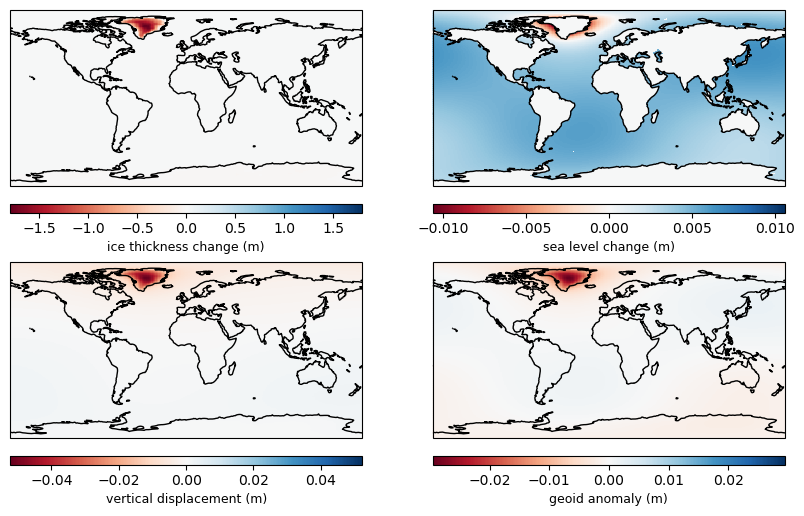

In [55]:
# set to true to use a random ice change model
use_random = False

if(use_random):
    #Q = RF.sobolev_covariance(L,s = 2,mu = 0.2)
    #zeta_north = -rhoi*SL.greenland_mask(sl0,ice0,val = 0.)*RF.random_field(Q) todo: add this
    #zeta_south = -rhoi*SL.antarctica_mask(sl0,ice0,val = 0.)*RF.random_field(Q)
    pass
else:
    zeta_north = -fingerprint.ice_density * fingerprint.southern_hemisphere_mask(value = 0) * fingerprint.ice_thickness
    zeta_south = -fingerprint.ice_density * fingerprint.northern_hemisphere_mask(value = 0) * fingerprint.ice_thickness
        
    
# normalise by GMSL contributions
GMSL_north = -fingerprint.integrate(zeta_north) / (fingerprint.water_density * fingerprint.ocean_area)
GMSL_south = -fingerprint.integrate(zeta_south) / (fingerprint.water_density * fingerprint.ocean_area)
zeta_north /= GMSL_north
zeta_south /= GMSL_south

# set the rate of GMSL change in mm
GMSL = 0.005

# set the northern and southern fractions
f_north = 0.1
f_south = 1.- f_north

# set the combined ice load
zeta = GMSL * (f_north * zeta_north + f_south * zeta_south)

# solve the fingerprint problem
response = fingerprint.solver(zeta)

# form the sea surface height directly
ssh = response.sl + response.u #+ psi/SL.g todo: add this

# define some masks
ice_mask = fingerprint.ice_mask(value = 0)
ocean_mask = fingerprint.ocean_mask(value = 0)

# plot the results globally
fig, ax = plt.subplots(2,2,figsize=(10,6),subplot_kw={'projection': crs.PlateCarree()})
plot_from_shgrid(ice_mask * zeta /fingerprint.ice_density, ax=ax[0,0])
plot_from_shgrid(ocean_mask * ssh, ax=ax[0,1])
plot_from_shgrid(-1 * response.u, ax=ax[1,0])
plot_from_shgrid(-1 * response.phi /fingerprint.gravitational_acceleration, ax=ax[1,1])
[[ax.coastlines() for ax in ax[:,i]] for i in range(2)]
titles = ['ice thickness change (m)', 'sea level change (m)', 'vertical displacement (m)', 'geoid anomaly (m)']
[ax[int(i/2), i%2].set_title(titles[i], y=-0.4, pad = 4, size=9) for i in range(4)]

In [ ]:
# set the observation point to Boston
lat =  42.3601
lon = -71.0589

# compute the adjoint load
zeta_d = fingerprint.sea_level_load(lat, lon, delta = 0).sl

# solve the sea level equation for SL^{\dagger} and plot
sl_d = fingerprint.solver(zeta_d).sl

# set the value of sea level directly from the field 
sl_direct = SL.point_evaluation(sl,lat,lon)

# evaluate the sea level by integration against the delta load
lhs = SL.surface_integral(zeta_d*sl)

# now get the value by integrating the sensitivity kernel against the direct load
rhs = SL.surface_integral(sl_d*zeta)

# print the values out along with the relative difference
print('direct sea level value = ',sl_direct)
print('left hand side         = ',lhs)
print('right hand side        = ',rhs)
print('relative difference    = ', np.abs((lhs-rhs)/lhs))

# define and plot the sensitivity kernel with respect to ice thickness
K = SL.rhoi*(1-C)*sl_d
land_mask = SL.land_mask(sl0,ice0)
SL.plot(land_mask*K,label = r'ice kernel (m$^{-2}$)',clim_scale = 0.1)

# re-define the kernel such that it is non-zero only where there is grounded ice
K_icemask = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K_icemask,label = r'ice kernel (m$^{-2}$)',marker = [lat,lon])

# compute the adjoint load for a SMOOTHED point load
zeta_d,_,_,_ = SL.sea_level_load(L,lat,lon,angle = 1.)

# solve the sea level equation for SL^{\dagger} and plot
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)

# set and plot the kernel projected onto regions of grounded ice
SL.plot(ice_mask * K_icemask, label = r'ice kernel (m$^{-2}$)', marker = [lat,lon])

SL.plot(sl_d, label = r'load kernel (m kg$^{-1}$)',clim_scale = 0.1)

